In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.autograd import Variable

from utils import *
from data_loader import get_train_loader

%matplotlib inline

# dir params
root_dir = './data/train/'

In [2]:
# ensuring reproducibility
torch.manual_seed(423212)

## View Data

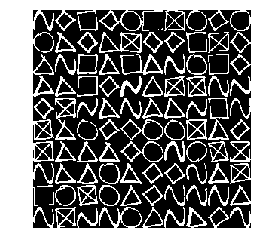

In [3]:
features = pickle.load(open('./data/dump/X_train.p', "rb"))

# randomly select 100
mask = np.random.choice(features.shape[0], 100, replace=False)  
sample = features[mask]
view_images(sample)

## Custom DataLoader

In [4]:
# transforms
train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(45),
    transforms.ToTensor(),
])

kwargs = {'shuffle': True, 'num_workers': 4}
train_loader = get_train_loader(root_dir, train_transform, **kwargs)

## Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 6)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [6]:
def accuracy(predicted, ground_truth):
    """
    Utility function for calculating the accuracy of the model.
    Params
    ------
    - predicted: (torch.FloatTensor)
    - ground_truth: (torch.LongTensor)
    Returns
    -------
    - acc: (float) % accuracy.
    """
    predicted = torch.max(predicted, 1)[1]
    total = len(ground_truth)
    correct = (predicted == ground_truth).sum().double()
    acc = 100 * (correct / total)
    return acc.data[0]

In [7]:
model = ConvNet()
optimizer = optim.Adam(model.parameters())

print('Number of model parameters: {:,}'.format(sum([p.data.nelement() for p in model.parameters()])))

Number of model parameters: 21,636


In [8]:
def train(epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        acc = accuracy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0], acc))

In [9]:
num_epochs = 50

for epoch in range(1,  num_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/311 (0%)]	Loss: 1.777363	Acc: 27.343750
Train Epoch: 1 [128/311 (33%)]	Loss: 1.761335	Acc: 27.343750
Train Epoch: 1 [110/311 (67%)]	Loss: 1.765963	Acc: 16.363636
Train Epoch: 2 [0/311 (0%)]	Loss: 1.741638	Acc: 21.093750
Train Epoch: 2 [128/311 (33%)]	Loss: 1.712892	Acc: 27.343750
Train Epoch: 2 [110/311 (67%)]	Loss: 1.686604	Acc: 30.909091
Train Epoch: 3 [0/311 (0%)]	Loss: 1.676963	Acc: 25.781250
Train Epoch: 3 [128/311 (33%)]	Loss: 1.639033	Acc: 28.125000
Train Epoch: 3 [110/311 (67%)]	Loss: 1.631614	Acc: 21.818182
Train Epoch: 4 [0/311 (0%)]	Loss: 1.572116	Acc: 36.718750
Train Epoch: 4 [128/311 (33%)]	Loss: 1.539236	Acc: 43.750000
Train Epoch: 4 [110/311 (67%)]	Loss: 1.539777	Acc: 41.818182
Train Epoch: 5 [0/311 (0%)]	Loss: 1.459679	Acc: 50.781250
Train Epoch: 5 [128/311 (33%)]	Loss: 1.408240	Acc: 51.562500
Train Epoch: 5 [110/311 (67%)]	Loss: 1.323909	Acc: 61.818182
Train Epoch: 6 [0/311 (0%)]	Loss: 1.291315	Acc: 58.593750
Train Epoch: 6 [128/311 (33%)]	Loss: 1.225

Train Epoch: 46 [0/311 (0%)]	Loss: 0.001099	Acc: 100.000000
Train Epoch: 46 [128/311 (33%)]	Loss: 0.005745	Acc: 100.000000
Train Epoch: 46 [110/311 (67%)]	Loss: 0.003147	Acc: 100.000000
Train Epoch: 47 [0/311 (0%)]	Loss: 0.002085	Acc: 100.000000
Train Epoch: 47 [128/311 (33%)]	Loss: 0.002976	Acc: 100.000000
Train Epoch: 47 [110/311 (67%)]	Loss: 0.006470	Acc: 100.000000
Train Epoch: 48 [0/311 (0%)]	Loss: 0.001695	Acc: 100.000000
Train Epoch: 48 [128/311 (33%)]	Loss: 0.003747	Acc: 100.000000
Train Epoch: 48 [110/311 (67%)]	Loss: 0.003741	Acc: 100.000000
Train Epoch: 49 [0/311 (0%)]	Loss: 0.003516	Acc: 100.000000
Train Epoch: 49 [128/311 (33%)]	Loss: 0.001741	Acc: 100.000000
Train Epoch: 49 [110/311 (67%)]	Loss: 0.004259	Acc: 100.000000
Train Epoch: 50 [0/311 (0%)]	Loss: 0.003389	Acc: 100.000000
Train Epoch: 50 [128/311 (33%)]	Loss: 0.002407	Acc: 100.000000
Train Epoch: 50 [110/311 (67%)]	Loss: 0.001501	Acc: 100.000000


In [10]:
test_data = []
for i in range(6):
    name = "./data/test/" + "X_test_" + str(i+1) + ".p"
    test_data.append(pickle.load(open(name, "rb")))

In [11]:
X_test = np.concatenate(test_data)
print(X_test.shape)

(90, 1, 28, 28)


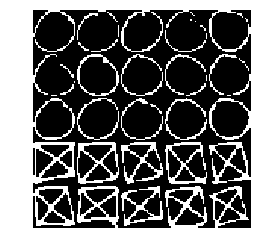

In [12]:
poop = np.transpose(X_test, [0, 2, 3, 1])
mask = np.arange(25)
view_images(poop[mask])

In [13]:
gd_truths = []
for i in range(6):
    gd_truth = [i]*15
    gd_truths.append(gd_truth)

# flatten
gd_truths = [x for sublist in gd_truths for x in sublist]

In [14]:
labels = np.array(gd_truths)
labels = np.resize(labels, [labels.shape[0], 1])

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(labels)

In [15]:
X_test.shape

torch.Size([90, 1, 28, 28])

In [16]:
def test():
    correct = 0
    data, target = Variable(X_test, volatile=True), Variable(y_test)
    output = model(data)
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    inco
    print('Accuracy: {}/{} ({:.0f}%)\n'.format(correct, X_test.size()[0],
        100. * correct / X_test.size()[0]))
    return pred

In [25]:
pred = test()

Accuracy: 89/90 (99%)



In [26]:
pred = list(pred.numpy().flatten())

In [21]:
correct_names = [num2name(x) for x in gd_truths]
prediction = list(pred.numpy().flatten())
prediction = [num2name(x) for x in prediction]
print("Gd Truth: {}".format(correct_names))
print("\n")
print("Predictions: {}".format(prediction))

Gd Truth: ['circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'cross', 'cross', 'cross', 'cross', 'cross', 'cross', 'cross', 'cross', 'cross', 'cross', 'cross', 'cross', 'cross', 'cross', 'cross', 'rhombus', 'rhombus', 'rhombus', 'rhombus', 'rhombus', 'rhombus', 'rhombus', 'rhombus', 'rhombus', 'rhombus', 'rhombus', 'rhombus', 'rhombus', 'rhombus', 'rhombus', 'square', 'square', 'square', 'square', 'square', 'square', 'square', 'square', 'square', 'square', 'square', 'square', 'square', 'square', 'square', 'squiggly', 'squiggly', 'squiggly', 'squiggly', 'squiggly', 'squiggly', 'squiggly', 'squiggly', 'squiggly', 'squiggly', 'squiggly', 'squiggly', 'squiggly', 'squiggly', 'squiggly', 'triangle', 'triangle', 'triangle', 'triangle', 'triangle', 'triangle', 'triangle', 'triangle', 'triangle', 'triangle', 'triangle', 'triangle', 'triangle', 'triangle', 'triangle']


Predictions: ['circle', 'ci

In [24]:
from sklearn.metrics import precision_recall_fscore_support

In [27]:
precision_recall_fscore_support(gd_truths, pred)

(array([ 1.    ,  0.9375,  1.    ,  1.    ,  1.    ,  1.    ]),
 array([ 1.        ,  1.        ,  1.        ,  1.        ,  0.93333333,  1.        ]),
 array([ 1.        ,  0.96774194,  1.        ,  1.        ,  0.96551724,  1.        ]),
 array([15, 15, 15, 15, 15, 15]))

circle: 1, 1, 1
cross: 0.9375, 1, 0.967
rhombus: 1, 1, 1
square: 1, 1, 1
squiggly: 1, 0.93333, 0.965
triangle: 1, 1, 1